In [1]:
# from google.colab import drive

# drive.mount("./gdrive", force_remount=True)

# %cd "./gdrive/My Drive/my_project_new/src/"
# !ls -l

In [1]:
import os
import datetime
import string
import json
import tensorflow as tf 
from config.config import json_file, source_path, output_path, raw_path
from config.config import target_path
from config.config import charset, batch_size, epochs, target_image_size
from config.config import buf_size, maxTextLength, ensemble_checkpoint_weights

os.makedirs(output_path, exist_ok=True)

print("source:", source_path)
print("output", output_path)
print("target", target_path)
print("charset:", charset)
print("buf_size:", buf_size)
print("max Text Length:", maxTextLength)
print("Ensemble weights paths:", ensemble_checkpoint_weights)

source: ../data/dataset_hdf5/dataset.hdf5
output ../output
target ../output/checkpoint_weights_bad_valid.hdf5
charset: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 
buf_size: 10000
max Text Length: 128
Ensemble weights paths: ['../output/checkpoint_weights_good_valid_1.hdf5']


In [2]:
from data.generator import DataGenerator_tf

# train_dgen = DataGenerator_tf(partition='train')

# valid_dgen = DataGenerator_tf(partition='valid')

# print(f"Train set size: {train_dgen.size}")
# print(f"Validation set size: {valid_dgen.size}")


In [3]:
from network.model import MyModel
from data.tokenizer import Tokenizer

tokenizer = Tokenizer()

model = MyModel(vocab_size=tokenizer.vocab_size,
                beam_width=30,
                stop_tolerance=20,
                reduce_tolerance=15, 
                top_paths=10)

model.compile(learning_rate=0.001)
# model.summary(output_path, "summary.txt")

model.load_checkpoint(target=target_path)
# callbacks = model.get_callbacks(logdir=output_path, checkpoint=target_path, verbose=1)


In [4]:
# def my_preprocess(img):
#     import cv2
#     import numpy as np
#     xp = [0, 64, 128, 192, 255]
#     fp = [0, 16, 128, 240, 255]
#     x = np.arange(256)
#     table = np.interp(x, xp, fp).astype('uint8')
#     img = cv2.LUT(img, table)
#     return img

def my_preprocess(img):
    import math
    import numpy as np
    from matplotlib import pyplot as plt
    from PIL import Image
    import cv2

    threshold_values = {}
    h = [1]

    def Hist(img):
       row, col = img.shape 
       y = np.zeros(256)
       for i in range(0,row):
          for j in range(0,col):
             y[img[i,j]] += 1
    #    x = np.arange(0,256)
    #    plt.bar(x, y, color='b', width=5, align='center', alpha=0.25)
    #    plt.show()
       return y


    def regenerate_img(img, t):
        row, col = img.shape 
        y = np.zeros((row, col))
        for i in range(0,row):
            for j in range(0,col):
                if img[i,j] > t:
                    y[i,j] = img[i,j]
                else:
                    y[i,j] = (-1*(t*(np.power((t-img[i,j])/t,0.3))-t)).astype(np.uint8) 
        return y



    def countPixel(h):
        cnt = 0
        for i in range(0, len(h)):
            if h[i]>0:
               cnt += h[i]
        return cnt


    def wieght(s, e):
        w = 0
        for i in range(s, e):
            w += h[i]
        return w


    def mean(s, e):
        m = 0
        w = wieght(s, e)
        for i in range(s, e):
            m += h[i] * i

        return m/float(w)


    def variance(s, e):
        v = 0
        m = mean(s, e)
        w = wieght(s, e)
        for i in range(s, e):
            v += ((i - m) **2) * h[i]
        v /= w
        return v


    def threshold(h):
        cnt = countPixel(h)
        for i in range(1, len(h)):
            vb = variance(0, i)
            wb = wieght(0, i) / float(cnt)
            mb = mean(0, i)

            vf = variance(i, len(h))
            wf = wieght(i, len(h)) / float(cnt)
            mf = mean(i, len(h))

            V2w = wb * (vb) + wf * (vf)
            V2b = wb * wf * (mb - mf)**2

            fw = open("trace.txt", "a")
            fw.write('T='+ str(i) + "\n")

            fw.write('Wb='+ str(wb) + "\n")
            fw.write('Mb='+ str(mb) + "\n")
            fw.write('Vb='+ str(vb) + "\n")

            fw.write('Wf='+ str(wf) + "\n")
            fw.write('Mf='+ str(mf) + "\n")
            fw.write('Vf='+ str(vf) + "\n")

            fw.write('within class variance='+ str(V2w) + "\n")
            fw.write('between class variance=' + str(V2b) + "\n")
            fw.write("\n")

            if not math.isnan(V2w):
                threshold_values[i] = V2w


    def get_optimal_threshold():
        min_V2w = min(threshold_values.values())
        optimal_threshold = [k for k, v in threshold_values.items() if v == min_V2w]
        print('optimal threshold', optimal_threshold[0])
        return optimal_threshold[0]

    h = Hist(img)
    threshold(h)
    op_thres = get_optimal_threshold()

    res = regenerate_img(img, op_thres)
    return res

optimal threshold 175
<ipython-input-4-79fd96ae4770>:67: RuntimeWarning: invalid value encountered in double_scalars
  return m/float(w)
optimal threshold 205
optimal threshold 186
optimal threshold 206
optimal threshold 198
optimal threshold 183
<class 'numpy.ndarray'> (6, 256, 98) 1
/home/voldemort/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)

####################################
Image 1


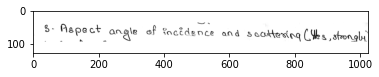


Prob.  - Predict
0.0000 - 3. ROpOOt. anglo of incidorice and sccttering 6ltos s stoonski
0.0000 - 3. ROpOOt. anglo of inciedorice and sccttering 6ltos s stoonski
0.0000 - 3. ROpOOt. anglo of incidorice and scattering 6ltos s stoonski
0.0000 - 3. ROpOOt. anglo of incedorice and sccttering 6ltos s stoonski
0.0000 - 3. ROpOOt. anglo of inciedorice and scattering 6ltos s stoonski
0.0000 - 3. ROpOOt. anglo of incidorice and sccttering 6llos s stoonski
0.0000 - 3. ROpOOt. anglo of incidorice and sccttersing 6ltos s stoonski
0.0000 - 3. ROpOOt. anglo of incidorice and sccattering 6ltos s stoonski
0.0000 - 3. ROpOOt. anglo of inciedorice and sccttering 6llos s stoonski
0.0000 - 3. ROpOOt. anglo of inciedorice and sccttersing 6ltos s stoonski
Image 2


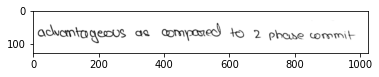


Prob.  - Predict
0.0084 - advomtageeus as composed to ? phave cromit
0.0053 - advomtageeus as composed to ? phave cramit
0.0048 - advomtageeus as compased to ? phave cromit
0.0040 - advomtageeus as composed to 2 phave cromit
0.0035 - advomtageeus as composed to ? phave coromit
0.0030 - advomtageeus as compased to ? phave cramit
0.0026 - advomtageeus as composed to ? phase cromit
0.0025 - advomtageeus as composed to 2 phave cramit
0.0025 - advamtageeus as composed to ? phave cromit
0.0023 - advomtageous as composed to ? phave cromit
Image 3


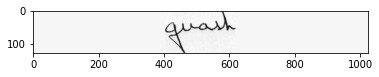


Prob.  - Predict
0.0626 - guash
0.0521 - guash 
0.0348 - geash
0.0261 - geash 
0.0171 - quash
0.0160 - gueash
0.0151 - qguash
0.0143 - guast
0.0136 - geuash
0.0129 - quash 
Image 4


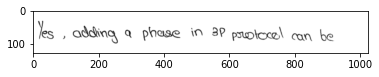


Prob.  - Predict
0.2262 - Yes , adding a phase in ap prootocel can be
0.0447 - Yes , adding a phase in ap protocel can be
0.0347 - Yes , adding a phose in ap prootocel can be
0.0330 - Yes , adding a phase in ap prostocel can be
0.0278 - Yes , adding a phuse in ap prootocel can be
0.0242 - Yes , adding a phaze in ap prootocel can be
0.0135 - Yes , adding a phase in ap preotocel can be
0.0130 - Yes , adding a phase in 9p prootocel can be
0.0105 - Yes , adding a phase in ap priootocel can be
0.0103 - Yes , adding a phase in ap prortocel can be
Image 5


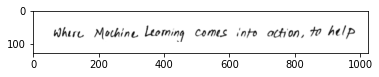


Prob.  - Predict
0.1491 - Where Machine Learning comes into action , to help
0.1240 - where Machine Learning comes into action , to help
0.0517 - Where Machine Leorning comes into action , to help
0.0431 - where Machine Leorning comes into action , to help
0.0352 - Where Machine learning comes into action , to help
0.0271 - Where Machine Learning comes into altion , to help
0.0231 - where Machine learning comes into action , to help
0.0227 - Where Machine hearning comes into action , to help
0.0223 - where Machine Learning comes into altion , to help
0.0221 - Where Mackine Learning comes into action , to help
Image 6


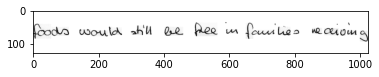


Prob.  - Predict
0.6077 - foods would still bl free in families receiving
0.1162 - foods would still bl free in families re ceiving
0.0272 - foods would still bl free in fomilies receiving
0.0179 - foods would still bl free in families receiving 
0.0134 - foods would still be free in families receiving
0.0127 - foods would still bl free in families receiving.
0.0078 - foods would still bl free in families recciving
0.0076 - foods would still bl free in families receivingg
0.0074 - foods would still bl free in families neceiving
0.0071 - foods would still bl fiee in families receiving

####################################


In [5]:
import matplotlib.pyplot as plt
import data.data_preprocessor as pp
img_path = ["./test-1.jpg", "./s.png", "./t.png", "./img2.png", "./w.png", "./x.png"]
imgs = []
for img in img_path:
  imgs.append(my_preprocess(pp.preprocess_image(img, target_image_size)))

x_test = pp.normalization(imgs)
predicts, probabilities = model.predict(x_test, ctc_decode=True)
predicts = tokenizer.sequences_to_texts(predicts)

print("\n####################################")
for i, (pred, prob) in enumerate(zip(predicts, probabilities)):
  print(f"Image {i + 1}")
  plt.imshow(pp.adjust_to_see(imgs[i]), cmap='gray')
  plt.show()
  
  print("\nProb.  - Predict")

  for (pd, pb) in zip(pred, prob):
      print(f"{pb:.4f} - {pd}")
print("\n####################################")

Model Predict
59/59 [==============================] - 489s 8s/step
<class 'numpy.ndarray'> (1861, 256, 98) 3
CTC Decode
 1/59 [..............................] - ETA: 11:19/home/voldemort/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
59/59 [==============================] - 723s 12s/step
Total results: 1861

He rose from his breakfast-nook bench
He  lose  from  is  breakfast-nook  bench 


and came into the livingroom , where
and  came  into  le  livingioon ,  where 


Heather and Steve stood aghast at
Heatler  and  eve  Nood  aglan  at 


his entrance . He came , almost falling
lis  entrance  .  He  came , atmon  falling 


forward in an ungainly shuffle , nec

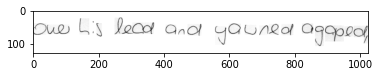

In [6]:
from textblob import TextBlob
from matplotlib import pyplot as plt
from data import data_preprocessor as pp

start_time = datetime.datetime.now()

test_dgen = DataGenerator_tf(partition='test')

# predict() function will return the predicts with the probabilities
predicts, _ = model.predict(x=test_dgen.create_dataset(),
                            steps=tf.math.ceil(test_dgen.size/test_dgen.batch_size),
                            ctc_decode=True,
                            verbose=1)
# decode to string
# predicts = [str(TextBlob(y).correct()) for y in [x[0] for x in test_dgen.tokenizer.sequences_to_texts(predicts)]]
predicts = [y for y in [x[0] for x in test_dgen.tokenizer.sequences_to_texts(predicts)]]
print("Total results:", len(predicts))

ground_truth = [x.decode() for x in test_dgen.labels]

total_time = datetime.datetime.now() - start_time

# mount predict corpus file
with open(os.path.join(output_path, "predict_sentences.txt"), "w") as lg:
    for pd, gt in zip(predicts, ground_truth):
        lg.write(f"TE_L {gt}\nTE_P {pd}\n")
   
for i, item in enumerate(test_dgen.imgs[:10]):
    print("=" * 1024, "\n")
    plt.imshow(pp.adjust_to_see(item), cmap="gray")
    plt.show()
    print(ground_truth[i])
    print(predicts[i], "\n")

with open(os.path.join(output_path, "eval_sentences.json"), "w") as f:
  json.dump({"predicts":predicts, "ground_truth":ground_truth}, f)

In [7]:
from data import evaluation

# with open(os.path.join(output_path, "eval.json"), "r") as f:
#   temp = json.load(f)
#   predicts = temp["predicts"]
#   ground_truth = temp["ground_truth"]

evaluate = evaluation.ocr_metrics(predicts, ground_truth)

e_corpus = "\n".join([
    f"Total test images:    {test_dgen.size}",
    f"Total time:           {total_time}",
    f"Time per item:        {total_time / test_dgen.size}\n",
    f"Metrics:",
    f"Character Error Rate: {evaluate[0]:.8f}",
    f"Word Error Rate:      {evaluate[1]:.8f}",
    f"Sequence Error Rate:  {evaluate[2]:.8f}"
])

with open(os.path.join(output_path, "evaluate_sentences.txt"), "w") as lg:
    lg.write(e_corpus)
    print(e_corpus)

Total test images:    1861
Total time:           0:35:25.509060
Time per item:        0:00:01.142133

Metrics:
Character Error Rate: 0.17375553
Word Error Rate:      0.21601617
Sequence Error Rate:  0.99946265
